# Clustering: Building Permits

## Documentation

[United States Census Bureau Building Permits Survey](https://www.census.gov/construction/bps/)

[ASCII files by State, Metropolitan Statistical Area (MSA), County or Place](https://www2.census.gov/econ/bps/)

[MSA Folder](https://www2.census.gov/econ/bps/Metro/)

[ASCII MSA Documentation](https://www2.census.gov/econ/bps/Documentation/msaasc.pdf)

In [1]:
import numpy as np
import pandas as pd

import re

import os.path
from os import path

from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.cluster import KMeans

import wrangle as wr
import preprocessing_permits as pr
import explore as ex
import model as mo

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option("display.max_columns", None)
plt.rc("figure", figsize=(16, 8))
sns.set_palette("colorblind")

In [3]:
df = pr.permits_preprocessing_mother_function()
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.""")
df

Our DataFrame contains 2,990 observations and 19 features.


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,five_or_more_units_bldgs_est_2y,five_or_more_units_value_est_2y,should_enter
0,Albany,NY,1997,30.0,425.0,17871000.0,14.166667,5.957000e+05,42049.411765,NaN,NaN,NaN,2.054924e+10,-0.655038,NaN,Albany_NY,NaN,NaN,False
1,Albany,NY,1998,47.0,1038.0,54232000.0,22.085106,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,2.465010,Albany_NY,NaN,NaN,False
2,Albany,NY,1999,39.0,515.0,24484000.0,13.205128,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,0.437662,Albany_NY,0.170673,0.472309,False
3,Albany,NY,2000,25.0,346.0,16130000.0,13.840000,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,0.626938,Albany_NY,0.625000,0.181828,False
4,Albany,NY,2001,56.0,502.0,24536000.0,8.964286,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,1.431902,Albany_NY,-0.266667,-0.570875,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985,York,PA,2015,3.0,53.0,3185000.0,17.666667,1.061667e+06,60094.339623,-0.666667,-0.320513,-0.449724,5.200240e+10,0.313639,0.418895,York_PA,-0.109677,0.450996,False
2986,York,PA,2016,3.0,34.0,1566000.0,11.333333,5.220000e+05,46058.823529,0.000000,-0.358491,-0.508320,4.928300e+10,-0.052294,0.518810,York_PA,0.093333,0.179576,False
2987,York,PA,2017,15.0,83.0,10204000.0,5.533333,6.802667e+05,122939.759036,4.000000,1.441176,5.515964,5.158824e+10,0.046775,6.224796,York_PA,-0.407407,0.268569,False
2988,York,PA,2018,2.0,26.0,2160000.0,13.000000,1.080000e+06,83076.923077,-0.866667,-0.686747,-0.788318,5.336251e+10,0.034393,0.204643,York_PA,-0.138996,-0.141515,False


In [4]:
df = df[df.year > 1997]

## Valuation per Building & Evolution Index

In [5]:
scaler = StandardScaler()
scaler.fit(df[["value_per_bldg", "ei"]])
df[["value_per_bldg", "ei"]] = scaler.transform(df[["value_per_bldg", "ei"]])

In [6]:
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [7]:
df[["value_per_bldg", "ei"]]

,value_per_bldg,ei
1,-0.387937,0.221831
2,-0.691854,-0.343723
3,-0.681799,-0.290922
4,-0.801416,-0.066368
5,-0.690285,-0.156146
...,...,...
2985,-0.441205,-0.348958
2986,-0.752972,-0.321086
2987,-0.661541,1.270670
2988,-0.430613,-0.408726


In [8]:
X = df[["value_per_bldg", "ei"]]

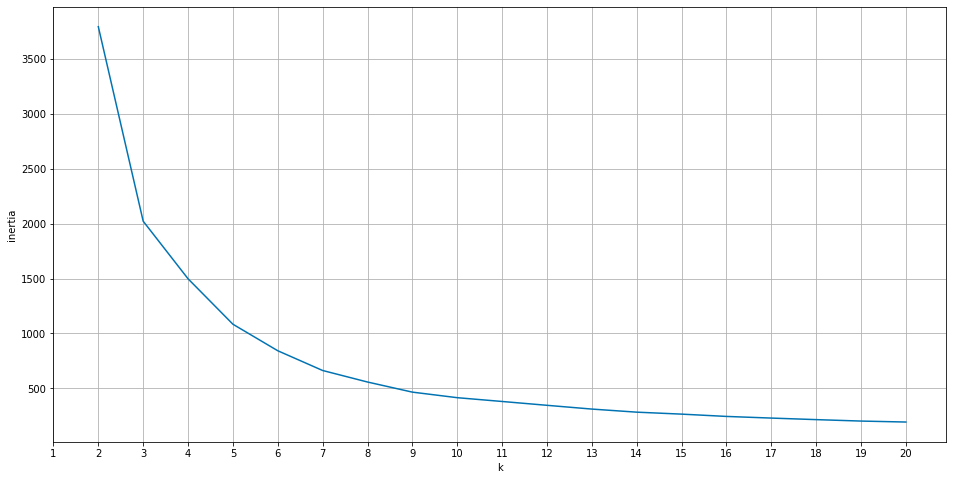

In [9]:
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [10]:
kmeans = KMeans(n_clusters=6, random_state=123)
kmeans.fit(X)

df["cluster"] = kmeans.predict(X)

In [11]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,value_per_bldg,ei
0,0.351883,-0.037357
1,0.166822,13.873166
2,4.932226,-0.004274
3,-0.098155,4.860367
4,1.813751,-0.099930
5,-0.542434,-0.137780


In [12]:
# centriods should be the same as the scaled model features mean
df.groupby("cluster")["value_per_bldg", "ei"].mean()

,value_per_bldg,ei
cluster,,
0,0.355263,-0.037583
1,0.166822,13.873166
2,4.932226,-0.004274
3,-0.098155,4.860367
4,1.816578,-0.099213
5,-0.541427,-0.137599


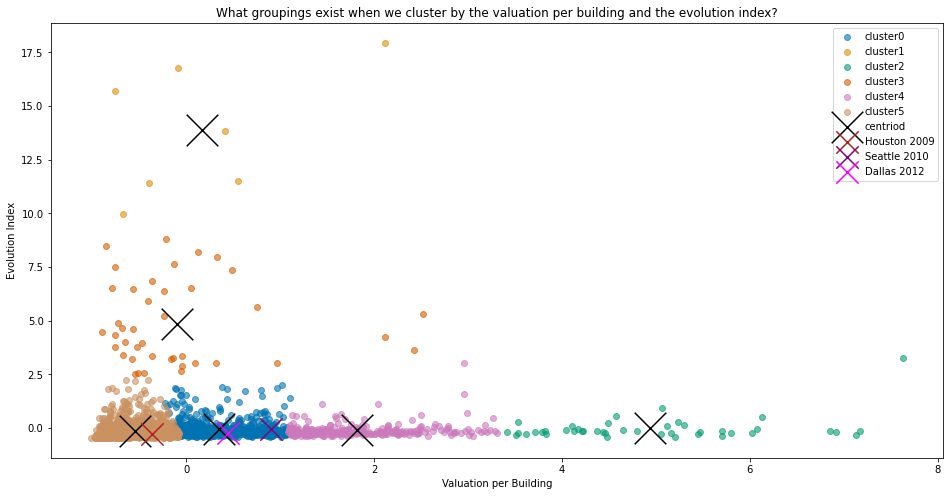

In [13]:
for cluster, subset in df.groupby("cluster"):
    plt.scatter(
        subset.value_per_bldg, subset.ei, label="cluster" + str(cluster), alpha=0.6
    )

centriods.plot.scatter(
    x="value_per_bldg",
    y="ei",
    c="black",
    marker="x",
    s=1000,
    ax=plt.gca(),
    label="centriod",
)

houston_2009 = df[(df.city == "Houston") & (df.state == "TX") & (df.year == 2009)]

houston_2009.plot.scatter(
    x="value_per_bldg",
    y="ei",
    c="firebrick",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Houston 2009",
)

seattle_2010 = df[(df.city == "Seattle") & (df.state == "WA") & (df.year == 2010)]

seattle_2010.plot.scatter(
    x="value_per_bldg",
    y="ei",
    c="purple",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Seattle 2010",
)

dallas_2012 = df[(df.city == "Dallas") & (df.state == "TX")  & (df.year == 2012)]

dallas_2012.plot.scatter(
    x="value_per_bldg",
    y="ei",
    c="magenta",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Dallas 2012",
)

plt.legend()
plt.title("What groupings exist when we cluster by the valuation per building and the evolution index?")
plt.xlabel("Valuation per Building")
plt.ylabel("Evolution Index")
plt.show()

**Takeaway**: This graph is showing me that it would be best to bin by valuation per building and disregard the evolution index as it really does not have anything to do with these clusters. We can cluster by some more meaningful features.

---
## Total Buildings & Total Valuation

In [14]:
df = pr.permits_preprocessing_mother_function()
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.""")
df

Our DataFrame contains 2,990 observations and 19 features.


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,five_or_more_units_bldgs_est_2y,five_or_more_units_value_est_2y,should_enter
0,Albany,NY,1997,30.0,425.0,17871000.0,14.166667,5.957000e+05,42049.411765,NaN,NaN,NaN,2.054924e+10,-0.655038,NaN,Albany_NY,NaN,NaN,False
1,Albany,NY,1998,47.0,1038.0,54232000.0,22.085106,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,2.465010,Albany_NY,NaN,NaN,False
2,Albany,NY,1999,39.0,515.0,24484000.0,13.205128,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,0.437662,Albany_NY,0.170673,0.472309,False
3,Albany,NY,2000,25.0,346.0,16130000.0,13.840000,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,0.626938,Albany_NY,0.625000,0.181828,False
4,Albany,NY,2001,56.0,502.0,24536000.0,8.964286,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,1.431902,Albany_NY,-0.266667,-0.570875,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985,York,PA,2015,3.0,53.0,3185000.0,17.666667,1.061667e+06,60094.339623,-0.666667,-0.320513,-0.449724,5.200240e+10,0.313639,0.418895,York_PA,-0.109677,0.450996,False
2986,York,PA,2016,3.0,34.0,1566000.0,11.333333,5.220000e+05,46058.823529,0.000000,-0.358491,-0.508320,4.928300e+10,-0.052294,0.518810,York_PA,0.093333,0.179576,False
2987,York,PA,2017,15.0,83.0,10204000.0,5.533333,6.802667e+05,122939.759036,4.000000,1.441176,5.515964,5.158824e+10,0.046775,6.224796,York_PA,-0.407407,0.268569,False
2988,York,PA,2018,2.0,26.0,2160000.0,13.000000,1.080000e+06,83076.923077,-0.866667,-0.686747,-0.788318,5.336251e+10,0.034393,0.204643,York_PA,-0.138996,-0.141515,False


In [15]:
df = df[df.year > 1997]

In [16]:
scaler = MinMaxScaler()
scaler.fit(df[["total_high_density_bldgs", "total_high_density_value"]])
df[["total_high_density_bldgs", "total_high_density_value"]] = scaler.transform(
    df[["total_high_density_bldgs", "total_high_density_value"]]
)

In [17]:
scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [18]:
df[["total_high_density_bldgs", "total_high_density_value"]]

,total_high_density_bldgs,total_high_density_value
1,0.018046,0.006384
2,0.014908,0.002873
3,0.009415,0.001887
4,0.021577,0.002879
5,0.018046,0.003481
...,...,...
2985,0.000785,0.000359
2986,0.000785,0.000167
2987,0.005492,0.001187
2988,0.000392,0.000238


In [19]:
X = df[["total_high_density_bldgs", "total_high_density_value"]]

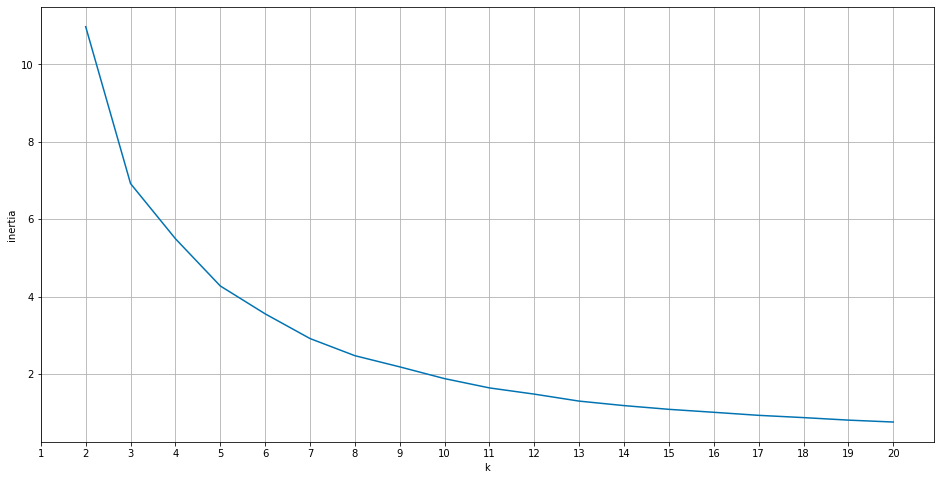

In [20]:
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [21]:
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans.fit(X)

df["cluster"] = kmeans.predict(X)

In [22]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,total_high_density_bldgs,total_high_density_value
0,0.014415,0.006599
1,0.224501,0.169592
2,0.503016,0.280016
3,0.092101,0.066046


In [23]:
# centriods should be the same as the scaled model features mean
df.groupby("cluster")["total_high_density_bldgs", "total_high_density_value"].mean()

,total_high_density_bldgs,total_high_density_value
cluster,,
0,0.014415,0.006599
1,0.224501,0.169592
2,0.503016,0.280016
3,0.092101,0.066046


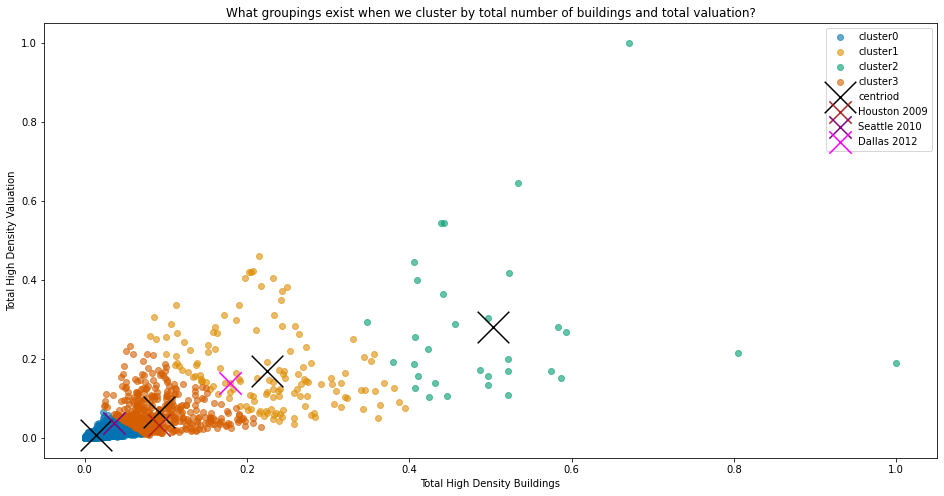

In [24]:
for cluster, subset in df.groupby("cluster"):
    plt.scatter(
        subset.total_high_density_bldgs, subset.total_high_density_value, label="cluster" + str(cluster), alpha=0.6
    )

centriods.plot.scatter(
    x="total_high_density_bldgs",
    y="total_high_density_value",
    c="black",
    marker="x",
    s=1000,
    ax=plt.gca(),
    label="centriod",
)

houston_2009 = df[(df.city == "Houston") & (df.state == "TX") & (df.year == 2009)]

houston_2009.plot.scatter(
    x="total_high_density_bldgs",
    y="total_high_density_value",
    c="firebrick",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Houston 2009",
)

seattle_2010 = df[(df.city == "Seattle") & (df.state == "WA") & (df.year == 2010)]

seattle_2010.plot.scatter(
    x="total_high_density_bldgs",
    y="total_high_density_value",
    c="purple",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Seattle 2010",
)

dallas_2012 = df[(df.city == "Dallas") & (df.state == "TX")  & (df.year == 2012)]

dallas_2012.plot.scatter(
    x="total_high_density_bldgs",
    y="total_high_density_value",
    c="magenta",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Dallas 2012",
)

plt.legend()
plt.title("What groupings exist when we cluster by total number of buildings and total valuation?")
plt.xlabel("Total High Density Buildings")
plt.ylabel("Total High Density Valuation")
plt.show()

**Takeaway**: Using the aggregated valuation and number of buildings gives us some better clusters. I think we need to take a step back and think as the stakeholder to determine the most valuable features by which to cluster.

---
## Average Units per Building & Valuation per Building

Let's take a step back. If I am the stakeholder, I am interested in properly prioritizing my resources so that they are most effectively used. So, what was the inital research question?

>"How many apartment units are being built in the U.S. everyday?"

Right. Clifton wants to know where the *most units* are being built. What features do we have that can answer that question? Maybe `avg_units_per_bldg` holds some insights on where, on average, the most units are being built?

If I'm Clifton, I also only want to pursue markets that are going to be most profitable. So I am thinking `value_per_bldg` will be a good measure of the average valuation of a structure.

In [25]:
df = pr.permits_preprocessing_mother_function()
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.""")
df

Our DataFrame contains 2,990 observations and 19 features.


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,five_or_more_units_bldgs_est_2y,five_or_more_units_value_est_2y,should_enter
0,Albany,NY,1997,30.0,425.0,17871000.0,14.166667,5.957000e+05,42049.411765,NaN,NaN,NaN,2.054924e+10,-0.655038,NaN,Albany_NY,NaN,NaN,False
1,Albany,NY,1998,47.0,1038.0,54232000.0,22.085106,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,2.465010,Albany_NY,NaN,NaN,False
2,Albany,NY,1999,39.0,515.0,24484000.0,13.205128,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,0.437662,Albany_NY,0.170673,0.472309,False
3,Albany,NY,2000,25.0,346.0,16130000.0,13.840000,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,0.626938,Albany_NY,0.625000,0.181828,False
4,Albany,NY,2001,56.0,502.0,24536000.0,8.964286,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,1.431902,Albany_NY,-0.266667,-0.570875,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985,York,PA,2015,3.0,53.0,3185000.0,17.666667,1.061667e+06,60094.339623,-0.666667,-0.320513,-0.449724,5.200240e+10,0.313639,0.418895,York_PA,-0.109677,0.450996,False
2986,York,PA,2016,3.0,34.0,1566000.0,11.333333,5.220000e+05,46058.823529,0.000000,-0.358491,-0.508320,4.928300e+10,-0.052294,0.518810,York_PA,0.093333,0.179576,False
2987,York,PA,2017,15.0,83.0,10204000.0,5.533333,6.802667e+05,122939.759036,4.000000,1.441176,5.515964,5.158824e+10,0.046775,6.224796,York_PA,-0.407407,0.268569,False
2988,York,PA,2018,2.0,26.0,2160000.0,13.000000,1.080000e+06,83076.923077,-0.866667,-0.686747,-0.788318,5.336251e+10,0.034393,0.204643,York_PA,-0.138996,-0.141515,False


In [26]:
df = df[df.year > 1997]

In [27]:
scaler = StandardScaler()
scaler.fit(df[["avg_units_per_bldg", "value_per_bldg"]])
df[["avg_units_per_bldg", "value_per_bldg"]] = scaler.transform(df[["avg_units_per_bldg", "value_per_bldg"]])

In [28]:
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [29]:
df[["avg_units_per_bldg", "value_per_bldg"]]

,avg_units_per_bldg,value_per_bldg
1,0.151808,-0.387937
2,-0.560042,-0.691854
3,-0.509148,-0.681799
4,-0.900002,-0.801416
5,-0.808448,-0.690285
...,...,...
2985,-0.202389,-0.441205
2986,-0.710091,-0.752972
2987,-1.175039,-0.661541
2988,-0.576485,-0.430613


In [30]:
X = df[["avg_units_per_bldg", "value_per_bldg"]]

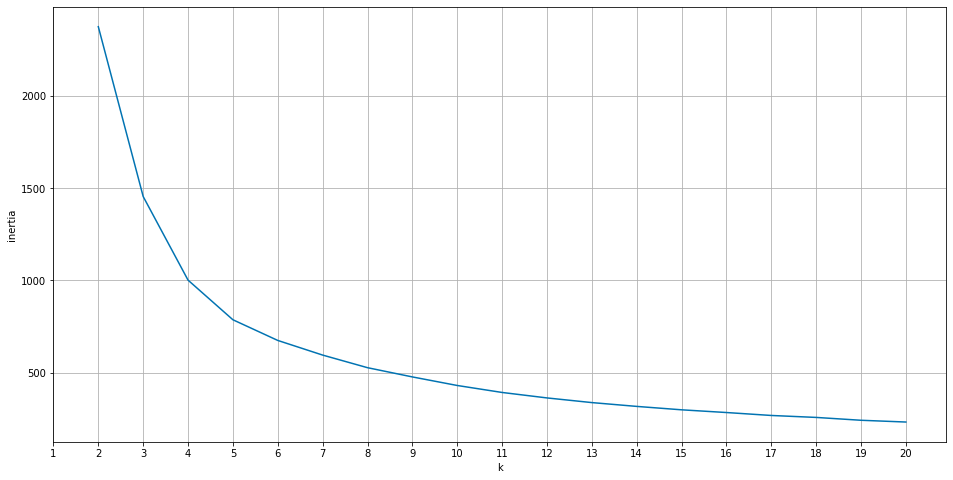

In [31]:
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [32]:
kmeans = KMeans(n_clusters=5, random_state=123)
kmeans.fit(X)

df["cluster"] = kmeans.predict(X)

In [33]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,avg_units_per_bldg,value_per_bldg
0,0.005453,-0.086709
1,0.922618,0.822586
2,4.470573,4.933278
3,-0.692081,-0.622758
4,2.080569,2.208156


In [34]:
# centriods should be the same as the scaled model features mean
df.groupby("cluster")["avg_units_per_bldg", "value_per_bldg"].mean()

,avg_units_per_bldg,value_per_bldg
cluster,,
0,0.004340,-0.087549
1,0.920736,0.820134
2,4.470573,4.933278
3,-0.692081,-0.622758
4,2.080569,2.208156


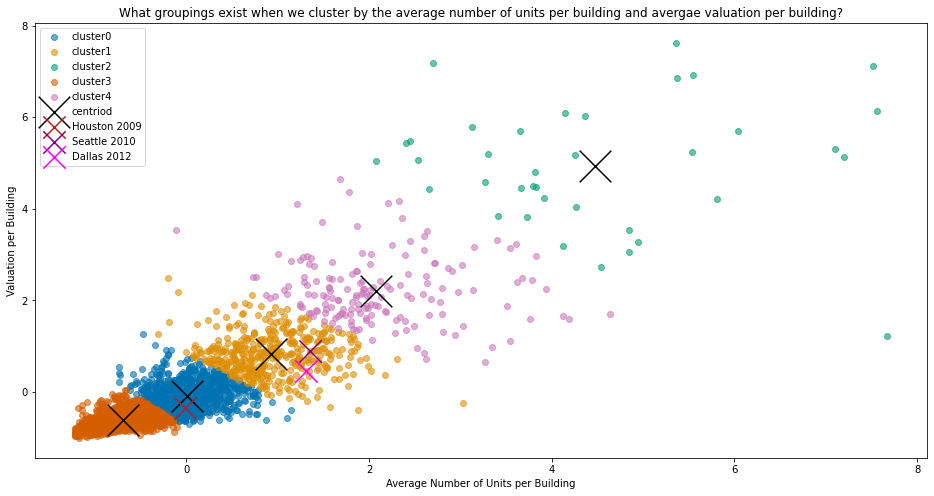

In [35]:
for cluster, subset in df.groupby("cluster"):
    plt.scatter(
        subset.avg_units_per_bldg, subset.value_per_bldg, label="cluster" + str(cluster), alpha=0.6
    )

centriods.plot.scatter(
    x="avg_units_per_bldg",
    y="value_per_bldg",
    c="black",
    marker="x",
    s=1000,
    ax=plt.gca(),
    label="centriod",
)

houston_2009 = df[(df.city == "Houston") & (df.state == "TX") & (df.year == 2009)]

houston_2009.plot.scatter(
    x="avg_units_per_bldg",
    y="value_per_bldg",
    c="firebrick",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Houston 2009",
)

seattle_2010 = df[(df.city == "Seattle") & (df.state == "WA") & (df.year == 2010)]

seattle_2010.plot.scatter(
    x="avg_units_per_bldg",
    y="value_per_bldg",
    c="purple",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Seattle 2010",
)

dallas_2012 = df[(df.city == "Dallas") & (df.state == "TX")  & (df.year == 2012)]

dallas_2012.plot.scatter(
    x="avg_units_per_bldg",
    y="value_per_bldg",
    c="magenta",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Dallas 2012",
)

plt.legend()
plt.title("What groupings exist when we cluster by the average number of units per building and avergae valuation per building?")
plt.xlabel("Average Number of Units per Building")
plt.ylabel("Valuation per Building")
plt.show()

**Takeaway**: I like these clusters. We can see that perhaps the most interesting markets (provided by Clifton) are emerging in value and growth in terms of quantity of units. Let's press on with some more features. Maybe substitue valuation with evolution index?

---
## Average Units per Building & Evolution Index

In [36]:
df = pr.permits_preprocessing_mother_function()
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.""")
df

Our DataFrame contains 2,990 observations and 19 features.


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,five_or_more_units_bldgs_est_2y,five_or_more_units_value_est_2y,should_enter
0,Albany,NY,1997,30.0,425.0,17871000.0,14.166667,5.957000e+05,42049.411765,NaN,NaN,NaN,2.054924e+10,-0.655038,NaN,Albany_NY,NaN,NaN,False
1,Albany,NY,1998,47.0,1038.0,54232000.0,22.085106,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,2.465010,Albany_NY,NaN,NaN,False
2,Albany,NY,1999,39.0,515.0,24484000.0,13.205128,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,0.437662,Albany_NY,0.170673,0.472309,False
3,Albany,NY,2000,25.0,346.0,16130000.0,13.840000,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,0.626938,Albany_NY,0.625000,0.181828,False
4,Albany,NY,2001,56.0,502.0,24536000.0,8.964286,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,1.431902,Albany_NY,-0.266667,-0.570875,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985,York,PA,2015,3.0,53.0,3185000.0,17.666667,1.061667e+06,60094.339623,-0.666667,-0.320513,-0.449724,5.200240e+10,0.313639,0.418895,York_PA,-0.109677,0.450996,False
2986,York,PA,2016,3.0,34.0,1566000.0,11.333333,5.220000e+05,46058.823529,0.000000,-0.358491,-0.508320,4.928300e+10,-0.052294,0.518810,York_PA,0.093333,0.179576,False
2987,York,PA,2017,15.0,83.0,10204000.0,5.533333,6.802667e+05,122939.759036,4.000000,1.441176,5.515964,5.158824e+10,0.046775,6.224796,York_PA,-0.407407,0.268569,False
2988,York,PA,2018,2.0,26.0,2160000.0,13.000000,1.080000e+06,83076.923077,-0.866667,-0.686747,-0.788318,5.336251e+10,0.034393,0.204643,York_PA,-0.138996,-0.141515,False


In [37]:
df = df[df.year > 1997]

In [38]:
scaler = PowerTransformer()
scaler.fit(df[["avg_units_per_bldg", "ei"]])
df[["avg_units_per_bldg", "ei"]] = scaler.transform(df[["avg_units_per_bldg", "ei"]])

In [39]:
scaler

PowerTransformer(copy=True, method='yeo-johnson', standardize=True)

In [40]:
df[["avg_units_per_bldg", "ei"]]

,avg_units_per_bldg,ei
1,0.499727,1.200626
2,-0.493115,-1.118050
3,-0.398138,-0.655825
4,-1.307457,0.503915
5,-1.049695,0.146820
...,...,...
2985,0.081753,-1.170629
2986,-0.808043,-0.905714
2987,-2.387242,2.050569
2988,-0.524968,-1.887526


In [41]:
X = df[["avg_units_per_bldg", "ei"]]

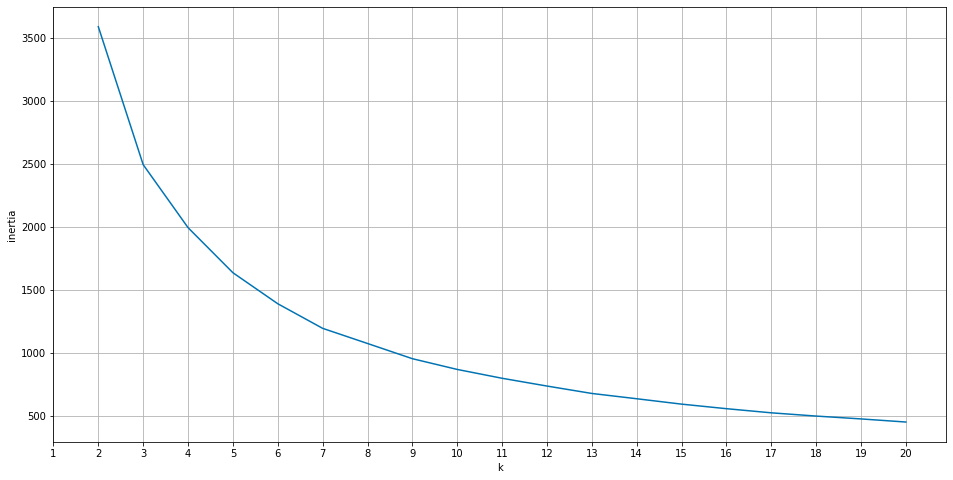

In [42]:
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [43]:
kmeans = KMeans(n_clusters=6, random_state=123)
kmeans.fit(X)

df["cluster"] = kmeans.predict(X)

In [44]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,avg_units_per_bldg,ei
0,0.134099,-0.882271
1,0.023700,1.710680
2,0.231324,0.344536
3,1.465900,0.120773
4,-1.407036,-1.636162
5,-0.995691,0.127961


In [45]:
# centriods should be the same as the scaled model features mean
df.groupby("cluster")["avg_units_per_bldg", "ei"].mean()

,avg_units_per_bldg,ei
cluster,,
0,0.133326,-0.881110
1,0.023700,1.710680
2,0.232997,0.346176
3,1.465900,0.120773
4,-1.407036,-1.636162
5,-0.994543,0.127512


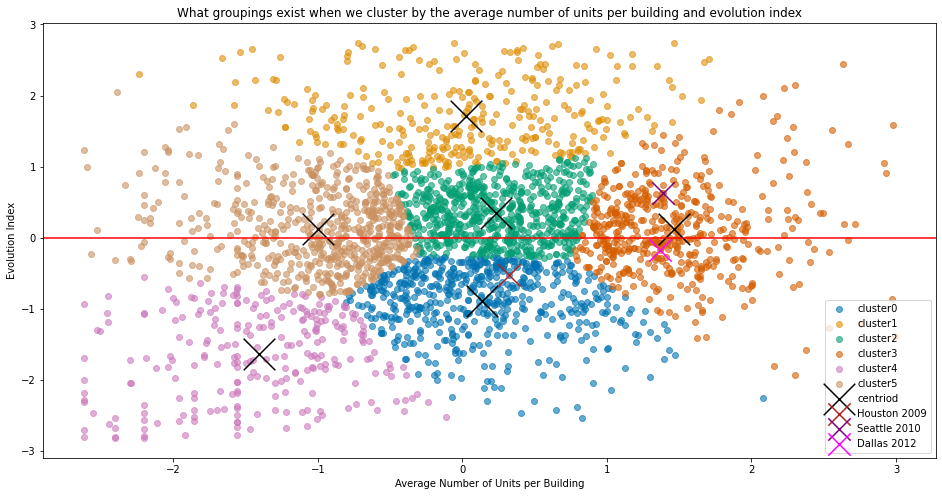

In [46]:
for cluster, subset in df.groupby("cluster"):
    plt.scatter(
        subset.avg_units_per_bldg, subset.ei, label="cluster" + str(cluster), alpha=0.6
    )

centriods.plot.scatter(
    x="avg_units_per_bldg",
    y="ei",
    c="black",
    marker="x",
    s=1000,
    ax=plt.gca(),
    label="centriod",
)

houston_2009 = df[(df.city == "Houston") & (df.state == "TX") & (df.year == 2009)]

houston_2009.plot.scatter(
    x="avg_units_per_bldg",
    y="ei",
    c="firebrick",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Houston 2009",
)

seattle_2010 = df[(df.city == "Seattle") & (df.state == "WA") & (df.year == 2010)]

seattle_2010.plot.scatter(
    x="avg_units_per_bldg",
    y="ei",
    c="purple",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Seattle 2010",
)

dallas_2012 = df[(df.city == "Dallas") & (df.state == "TX")  & (df.year == 2012)]

dallas_2012.plot.scatter(
    x="avg_units_per_bldg",
    y="ei",
    c="magenta",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Dallas 2012",
)

plt.legend()
plt.title("What groupings exist when we cluster by the average number of units per building and evolution index")
plt.xlabel("Average Number of Units per Building")
plt.ylabel("Evolution Index")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

**Takeaway**: Wow! Very interesting clusters here. We can see that the markets of interest are those that have not quite "boomed" according to our evolution index, but have a relatively high number of units being built.

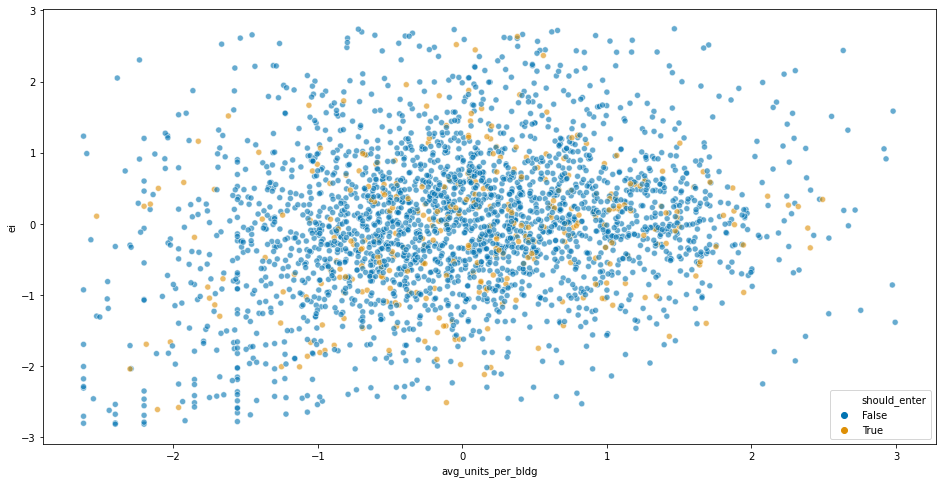

In [47]:
sns.scatterplot(df.avg_units_per_bldg, df.ei, alpha=0.6, hue=df.should_enter)

---
## Average Units per Building & Market Share

In [48]:
df = pr.permits_preprocessing_mother_function()
print(f"""Our DataFrame contains {df.shape[0]:,} observations and {df.shape[1]} features.""")
df

Our DataFrame contains 2,990 observations and 19 features.


,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,five_or_more_units_bldgs_est_2y,five_or_more_units_value_est_2y,should_enter
0,Albany,NY,1997,30.0,425.0,17871000.0,14.166667,5.957000e+05,42049.411765,NaN,NaN,NaN,2.054924e+10,-0.655038,NaN,Albany_NY,NaN,NaN,False
1,Albany,NY,1998,47.0,1038.0,54232000.0,22.085106,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,2.465010,Albany_NY,NaN,NaN,False
2,Albany,NY,1999,39.0,515.0,24484000.0,13.205128,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,0.437662,Albany_NY,0.170673,0.472309,False
3,Albany,NY,2000,25.0,346.0,16130000.0,13.840000,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,0.626938,Albany_NY,0.625000,0.181828,False
4,Albany,NY,2001,56.0,502.0,24536000.0,8.964286,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,1.431902,Albany_NY,-0.266667,-0.570875,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985,York,PA,2015,3.0,53.0,3185000.0,17.666667,1.061667e+06,60094.339623,-0.666667,-0.320513,-0.449724,5.200240e+10,0.313639,0.418895,York_PA,-0.109677,0.450996,False
2986,York,PA,2016,3.0,34.0,1566000.0,11.333333,5.220000e+05,46058.823529,0.000000,-0.358491,-0.508320,4.928300e+10,-0.052294,0.518810,York_PA,0.093333,0.179576,False
2987,York,PA,2017,15.0,83.0,10204000.0,5.533333,6.802667e+05,122939.759036,4.000000,1.441176,5.515964,5.158824e+10,0.046775,6.224796,York_PA,-0.407407,0.268569,False
2988,York,PA,2018,2.0,26.0,2160000.0,13.000000,1.080000e+06,83076.923077,-0.866667,-0.686747,-0.788318,5.336251e+10,0.034393,0.204643,York_PA,-0.138996,-0.141515,False


In [49]:
df['market_share'] = (df.total_high_density_value / df.market_volume)

In [50]:
df

,city,state,year,total_high_density_bldgs,total_high_density_units,total_high_density_value,avg_units_per_bldg,value_per_bldg,value_per_unit,city_state_high_density_bldgs_delta_pct,city_state_high_density_units_delta_pct,city_state_high_density_value_delta_pct,market_volume,market_volume_delta_pct,ei,city_state,five_or_more_units_bldgs_est_2y,five_or_more_units_value_est_2y,should_enter,market_share
0,Albany,NY,1997,30.0,425.0,17871000.0,14.166667,5.957000e+05,42049.411765,NaN,NaN,NaN,2.054924e+10,-0.655038,NaN,Albany_NY,NaN,NaN,False,0.000870
1,Albany,NY,1998,47.0,1038.0,54232000.0,22.085106,1.153872e+06,52246.628131,0.566667,1.442353,2.034637,2.529787e+10,0.231085,2.465010,Albany_NY,NaN,NaN,False,0.002144
2,Albany,NY,1999,39.0,515.0,24484000.0,13.205128,6.277949e+05,47541.747573,-0.170213,-0.503854,-0.548532,2.609590e+10,0.031545,0.437662,Albany_NY,0.170673,0.472309,False,0.000938
3,Albany,NY,2000,25.0,346.0,16130000.0,13.840000,6.452000e+05,46618.497110,-0.358974,-0.328155,-0.341202,2.742204e+10,0.050818,0.626938,Albany_NY,0.625000,0.181828,False,0.000588
4,Albany,NY,2001,56.0,502.0,24536000.0,8.964286,4.381429e+05,48876.494024,1.240000,0.450867,0.521141,2.913103e+10,0.062322,1.431902,Albany_NY,-0.266667,-0.570875,False,0.000842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985,York,PA,2015,3.0,53.0,3185000.0,17.666667,1.061667e+06,60094.339623,-0.666667,-0.320513,-0.449724,5.200240e+10,0.313639,0.418895,York_PA,-0.109677,0.450996,False,0.000061
2986,York,PA,2016,3.0,34.0,1566000.0,11.333333,5.220000e+05,46058.823529,0.000000,-0.358491,-0.508320,4.928300e+10,-0.052294,0.518810,York_PA,0.093333,0.179576,False,0.000032
2987,York,PA,2017,15.0,83.0,10204000.0,5.533333,6.802667e+05,122939.759036,4.000000,1.441176,5.515964,5.158824e+10,0.046775,6.224796,York_PA,-0.407407,0.268569,False,0.000198
2988,York,PA,2018,2.0,26.0,2160000.0,13.000000,1.080000e+06,83076.923077,-0.866667,-0.686747,-0.788318,5.336251e+10,0.034393,0.204643,York_PA,-0.138996,-0.141515,False,0.000040


In [51]:
df = df[df.year > 1997]

In [52]:
scaler = PowerTransformer(method="box-cox")
scaler.fit(df[["avg_units_per_bldg", "market_share"]])
df[["avg_units_per_bldg", "market_share"]] = scaler.transform(df[["avg_units_per_bldg", "market_share"]])

In [53]:
scaler

PowerTransformer(copy=True, method='box-cox', standardize=True)

In [54]:
df[["avg_units_per_bldg", "market_share"]]

,avg_units_per_bldg,market_share
1,0.496335,0.107142
2,-0.488785,-0.379937
3,-0.394419,-0.655201
4,-1.303281,-0.443549
5,-1.044102,-0.381989
...,...,...
2985,0.081626,-1.989250
2986,-0.802408,-2.376357
2987,-2.413635,-1.297825
2988,-0.520452,-2.233561


In [55]:
X = df[["avg_units_per_bldg", "market_share"]]

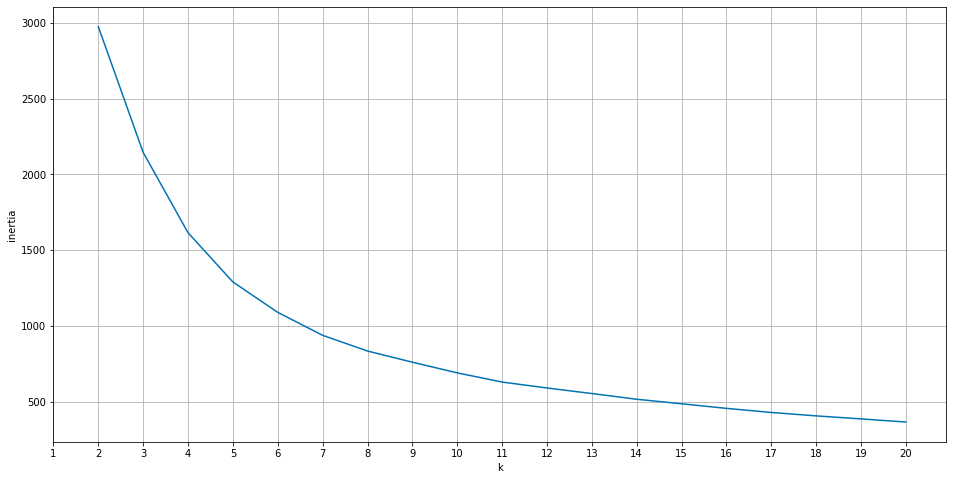

In [56]:
pd.Series({k: ex.get_inertia(k, X) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [57]:
kmeans = KMeans(n_clusters=5, random_state=123)
kmeans.fit(X)

df["cluster"] = kmeans.predict(X)

In [58]:
centriods = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centriods

,avg_units_per_bldg,market_share
0,0.977346,-0.267933
1,-0.086329,0.606248
2,-0.553556,-0.531826
3,1.131139,1.488764
4,-1.622047,-1.496045


In [59]:
# centriods should be the same as the scaled model features mean
df.groupby("cluster")["avg_units_per_bldg", "market_share"].mean()

,avg_units_per_bldg,market_share
cluster,,
0,0.977346,-0.267933
1,-0.086329,0.606248
2,-0.553556,-0.531826
3,1.131139,1.488764
4,-1.622047,-1.496045


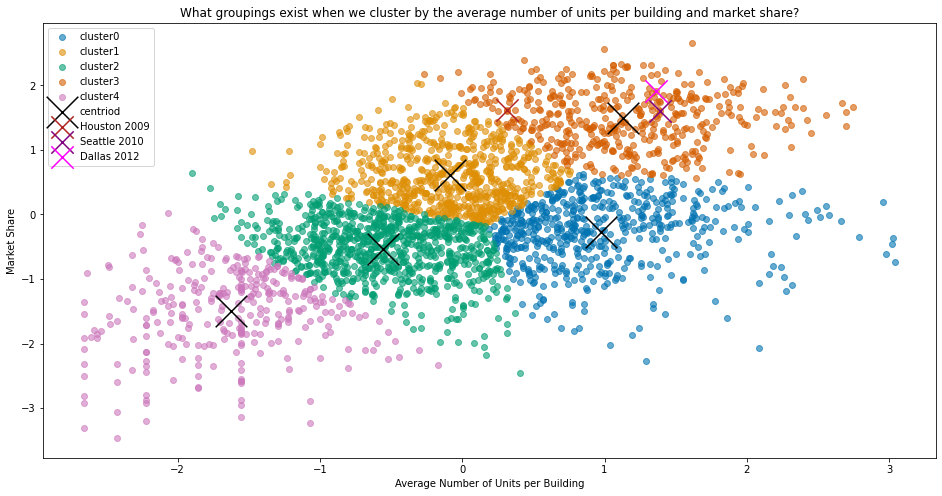

In [60]:
for cluster, subset in df.groupby("cluster"):
    plt.scatter(
        subset.avg_units_per_bldg, subset.market_share, label="cluster" + str(cluster), alpha=0.6
    )

centriods.plot.scatter(
    x="avg_units_per_bldg",
    y="market_share",
    c="black",
    marker="x",
    s=1000,
    ax=plt.gca(),
    label="centriod",
)

houston_2009 = df[(df.city == "Houston") & (df.state == "TX") & (df.year == 2009)]

houston_2009.plot.scatter(
    x="avg_units_per_bldg",
    y="market_share",
    c="firebrick",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Houston 2009",
)

seattle_2010 = df[(df.city == "Seattle") & (df.state == "WA") & (df.year == 2010)]

seattle_2010.plot.scatter(
    x="avg_units_per_bldg",
    y="market_share",
    c="purple",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Seattle 2010",
)

dallas_2012 = df[(df.city == "Dallas") & (df.state == "TX")  & (df.year == 2012)]

dallas_2012.plot.scatter(
    x="avg_units_per_bldg",
    y="market_share",
    c="magenta",
    marker="x",
    s=500,
    ax=plt.gca(),
    label="Dallas 2012",
)

plt.legend()
plt.title("What groupings exist when we cluster by the average number of units per building and market share?")
plt.xlabel("Average Number of Units per Building")
plt.ylabel("Market Share")
# plt.axhline(y=0, color='r', linestyle='-')
plt.show()

**Takeaway**: All of our ID markets are in the same cluster

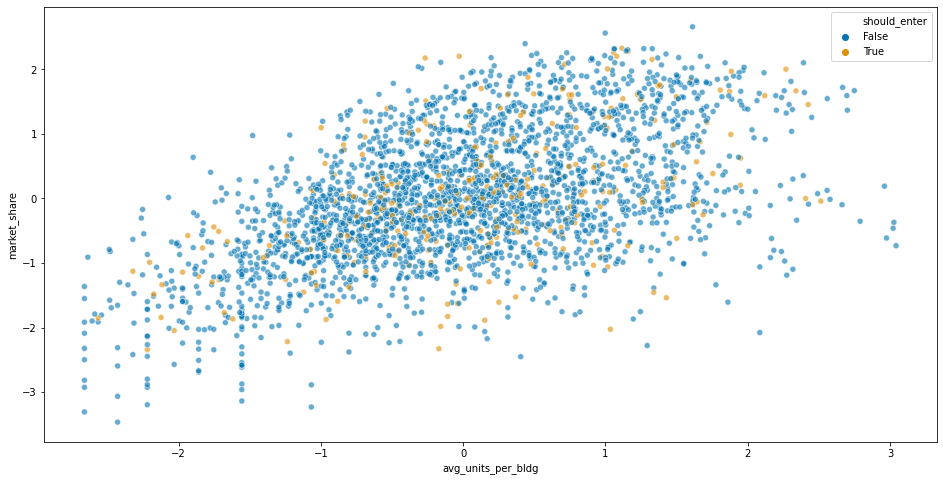

In [61]:
sns.scatterplot(df.avg_units_per_bldg, df.market_share, alpha=0.6, hue=df.should_enter)